# NFC Setup & Instructions
### Studying blocking cards
This notebook provides a set of tools to analyze NFC communication (reader to tag) via a modded RTL-SDR.

1. [INSTALL](#INSTALL) installation guide for arch linux (easily portable to other distros/macos)
2. [Libraries and loading signals](#Libraries-and-loading-signals) loading recorded signals in python.
2. [GNURadio companion & libnfc](#GNURadio-companion-and-libnfc) signal acquisition via RTL-SDR.
3. [Demodulation](#Demodulation) of an NFC communication between a reader and a card.
4. [Cards](#Cards) brief explaination of how cards respond to the reader. In this section we understand what is the best way to send commands to the card in presence of a blocking card.
5. [Blocking Cards Attacks](#Blocking-Cards-Attacks) explaination of how blocking cards interfere in the communication (with [profiling](Profiling.ipynb)). In addition an explaination on how to remove the effects by [taking the mean of multiple messages](Blocking%20Cards%20-%20Demodulation%20with%20Mean.ipynb) of a blocking card is given. 
6. [Simulation](#Simulation) of noise interferring in a clean communication and demodulation
7. [Appendix](#Appendix) including nfc-tools (android) demodulation with ISO-DEP card

Objective of this study: find out if a smart demodulation technique or noise removal technique can help in presence of a blocking card.

# INSTALL

Clone these repos:
```shell
git clone https://github.com/blackwiz4rd/rtl-sdr-nfc # where this file belongs to
git clone https://github.com/blackwiz4rd/apdu_smartcard_exchange_tester
```

In this repo you will find *gnuradio* folder to record nfc communication with rtl-sdr.

Install programs:

```shell
yay -S jupyterlab
yay -S urh # make sure it is >= 2.9.2 (https://github.com/jopohl/urh/issues/848)
yay -S gqrx
yay -S gnuradio
```

Install blackwiz4rd/libnfc:
```shell
git clone https://github.com/blackwiz4rd/libnfc
sudo cp contrib/udev/93-pn53x.rules /lib/udev/rules.d/
yay -S base-devel 
yay -S libusb libusb-compat usbutils
autoreconf -vis
./configure --prefix=/usr --sysconfdir=/etc --with-drivers=pn532_uart,acr122_usb # see ./configure --help to choose drivers
make install # run again if you change libnfc
sudo make install # run again if you change libnfc
```

Add modproble config:
```
/etc/modprobe.d/rtl-sdr.conf 
blacklist dvb_usb_rtl28xxu
/etc/modprobe.d/libnfc.conf 
install nfc /bin/false
install pn533 /bin/false
install pn533_usb /bin/false
```

# Libraries and loading signals

`nfc_signal_offline.py` is the key library, it includes functions to demodulate the signal and to check the success rate of the demodulation process if a known sequence is passed. `nfc_signal_help.py` implements functions to load signals.

In [3]:
from common_imports import *

# GNURadio companion and libnfc

The hardware mod of an RTL-SDR for HF frequencies guarantees a reliable signal capture for NFC communications. After the mod, the device is similar to the hardware design in: https://ieeexplore.ieee.org/document/6812011/ 

Resources:
- how the rtl-sdr works: https://web.archive.org/web/20191120002326/http://ajoo.blog/intro-to-rtl-sdr-part-i-principles-and-hardware.html
- hardware modification: http://blog.livedoor.jp/bh5ea20tb/archives/4263275.html (use google translate)

Suggestion: You can view the signal captured in GnuRadio by loading it in *Universal Radio Hacker*.

There are two useful programs you can use to communicate with the cards and analyze blocking cards.
- `mf-ultralight/apdu_get_data.c` enables you to send known APDUs (with known bytes) to a Mifare Ultralight Card without password.
- `magnetic-field-up-profiling/magnetic_field_up.c` turns on the magnetic field of the reader, without sending any command. It is useful for profiling blocking cards.

Before running `apdu_get_data.c`, a modified libnfc version is required (see [INSTALL](#INSTALL)): https://github.com/blackwiz4rd/libnfc/commit/188ab4738e36a1b0e29e02161f7d381f69c588bd.

Modified functions in libnfc:
- `nfc_initiator_init_collision`: new function for setting up the device, this function is useful to set up the reader registers correctly.
- `pn53x_initiator_transceive_bits`: see modification below.

The most relevant change is in `pn53x_initiator_transceive_bits`. By checking the size of the received file, possible segmentation fault is avoided:
```
  if (szRx - 1 > 0) // solves possible segmentation fault on bit collisions
    szFrameBits = ((szRx - 1 - ((ui8Bits == 0) ? 0 : 1)) * 8) + ui8Bits;
  else 
    szFrameBits = 0;
```

Run the command below to establish a reader/card communication by sending known bytes. You can also build your own C program that relies on nfclib or use `apdu_get_data.c` as a starting point.

In [3]:
# !../apdu_smartcard_exchange_tester/mf-ultralight/apdu_get_data 1 80 # may need sudo, second parameter stands for number of times you want to repeat the commands flow

You can record signals with GnuRadio and you need to apply a low pass filter, to remove possible signals out-of-band (e.g. it is better to have a look in gqrx for out-of-band signals or signals that add up to the signal you wish to record before any transmission), then take the magnitude of complex samples and save them into a file.

<b>Note</b>: the -300m constant was added to make it easier to view the signal in *Universal Radio Hacker*.

![title](imgs/gnuradio/gnuradio-trim.png)
![title](imgs/gqrx/mfclassic.png)

# Demodulation

We have introduced a library to demodulate signals in python, which:
1. identifies the electromagnetic field start and end point.
2. identifies the messages (and can distinguish between reader and tag)
3. demodulates the messages

There are three approaches for demodulation that were tempted in the past for demodulating NFC with RTL-SDR. Our approach is based on them:
- "jump-based": https://github.com/Iskuri/RTLSDR-NFC/blob/master/main.c
- "gap-based": https://github.com/jcrona/gr-nfc/blob/master/lib/modified_miller_decoder_impl.cc
- "pattern detection": https://github.com/josevcm/nfc-signal-monitor (this is also a real-time NFC demodulator) this approach should be very effective but it is complex to apply for our purpose
- "count-based": used in the notebook. Our demodulation process is a modified version of "jump-based".

See [ISO 14443-2](https://www.iso.org/standard/73597.html) to understand the protocol specifications.
The modulations in the protocol are now summarized. Refer to `perform_demodulation()` in `nfc_signal_offline.py` for the code implementation.

#### Modified Miller (reader modulation)

samples per quarter of symbol: 4 (e.g. a 1 is 1111 in the GnuRadio raw files).

Sequences:

X: --.- 1101 0xd

Y: ---- 1111 0xf

Z: .--- 0111 0x7

Coding of information bits:

- logic "1": X
- logic "0": Y, Z from second logic0 (logic0|logic0) or if there was a start (S|logic0)
- "S": Z
- "E": logic0|Y
- no information: Y|Y

#### Manchester (tag modulation)

samples per half symbol: 8 (e.g a 0 is 00000000 in the GnuRadio raw files).

Sequences:

D: .- 01 0x1

E: -. 10 0x2

F: -- 11 0x3

Coding of information bits:

- logic "1": D
- logic "0": E
- "S": D
- "E": F
- no information: no subcarrier


Some useful constants uesd in the notebook are summariezed below:
- $f_{sub} = 847.5kHz$, subcarrier frequency
- $f_{s} = f_{sub}*2$, sampling frequency
- $f_{c} = 13.56MHz$, center frequency
- $D_{b} = \frac{f_c}{128} \approx 106kHz$, bit rate ($106\frac{kb}{s}$)
- $ETU = \frac{1}{D_{b}} = 9.44\mu s$

- $N_{samples/symbol} = \frac{f_{s}}{D_{b}} = 16$, number of samples per symbol. To code one symbol for the modulation you have 16 samples (bits).


With higher sample rate (larger memory consumption), considering a $f_{s}<f_{s_{max}}\approx2.5MHz$ ([RTL-SDR limitation reference](https://osmocom.org/projects/rtl-sdr/wiki/Rtl-sdr)):
- $f_{sub} = 847.5kHz$
- $f_{s} = f_{sub}*3$, sampling frequency
- $f_{c} = 13.56MHz$, center frequency
- $D_{b} = \frac{f_c}{128} \approx 106kHz$, bit rate ($106\frac{kb}{s}$)
- $ETU = \frac{1}{D_{b}} = 9.44\mu s$

- $N_{samples/symbol} = \frac{f_{s}}{D_{b}} = 24$, number of samples per symbol. To code one symbol for the modulation you have 24 samples (bits).

- $f_{blocking} = f_{c} (1 \pm d*\theta)$

## Clean Communication

A clean communication demodulation is now presented with the relative plots.

In [4]:
# Mifare Ultralight EV1
# data = load_mag('../data/clean_signal_one_card.raw')
data = load_mag('../data/ev1_clean/trim_clean_4_na_trim.raw')

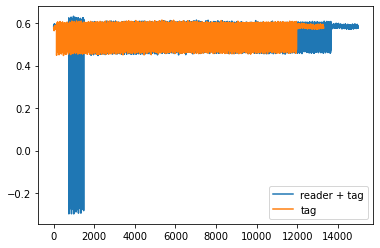

In [5]:
reader_tag = data[int(0.5e6):int(0.5e6)+15000]
tag = data[int(0.5e6)+1700:int(0.5e6)+15000]
plt.plot(reader_tag, label="reader + tag")
plt.plot(tag, label="tag")
plt.legend()

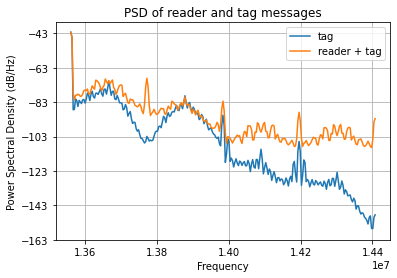

In [6]:
# TODO: plot after demodulation
# plt.plot(tag)
plt.title('PSD of reader and tag messages')
plt.psd(tag, Fs=1695000, NFFT=512, Fc=Fc, label='tag')
plt.psd(reader_tag, Fs=1695000, NFFT=512, Fc=Fc, label='reader + tag')
plt.legend()

In [7]:
expected_file = libnfc_file = '../data/ev1_clean/trim_clean_4_na_trim.txt'

In [8]:
start = time()
# s = NfcSignal(data, expectd_libnfc = expectd_libnfc, show_plots = False, Fs=1695000, libnfc_file = libnfc_file, attack_blocking = True, wrong_message_index = 8, message_repetitions=80)
s = NfcSignal(data, 
      expected_file=expected_file, 
      libnfc_file=libnfc_file, 
      attack_mode=0, 
      mean_samples=0, 
      message_batch_size=8)
end = time()
print(f"init duration {end-start}")

init duration 8.447922468185425


In [9]:
# plot first reader message (to know the amplitude of the card's response and set it above in NfcSignal)

In [10]:
s.start_demodulation()

In [11]:
s.demodulation_stats()

(INFO) RTL-SDR
(INFO) 	correct reader demodulations over detected reader messages: 32/32 = 1.000000
(INFO) 	correct tag demodulations over detected tag messages: 24/24 = 1.000000
(INFO) 	correct tag demodulations over total tag replies without blck: 24/24 = 1.000000
(INFO) LIBNFC
(INFO) 	correct tag demodulations over total tag replies without blck: 24/24 = 1.000000
(INFO) RTL-SDR and LIBNFC comparison (tag only)
(INFO) 	Correct messages in rtlsdr and wrong in libnfc 0 (are we doing better than libnfc?)
(INFO) 	Correct messages in libnfc and wrong in rtlsdr 0 (are we doing worse than libnfc?)
(INFO) 	Correct messages in libnfc or rtlsdr 24 (how are we doing overall?)


,rtl_reader_correct,rtl_reader_tot,rtl_tag_correct,rtl_tag_detected,tag_expected_tot,libnfc_tag_correct,correct_rtlsdr_wrong_libnfc,correct_libnfc_wrong_rtlsdr,correct_libnfc_rtlsdr,means
0,32,32,24,24,24,24,0,0,24,0


In [12]:
# take smaller version of the signal for the following prints

2775980 1695000


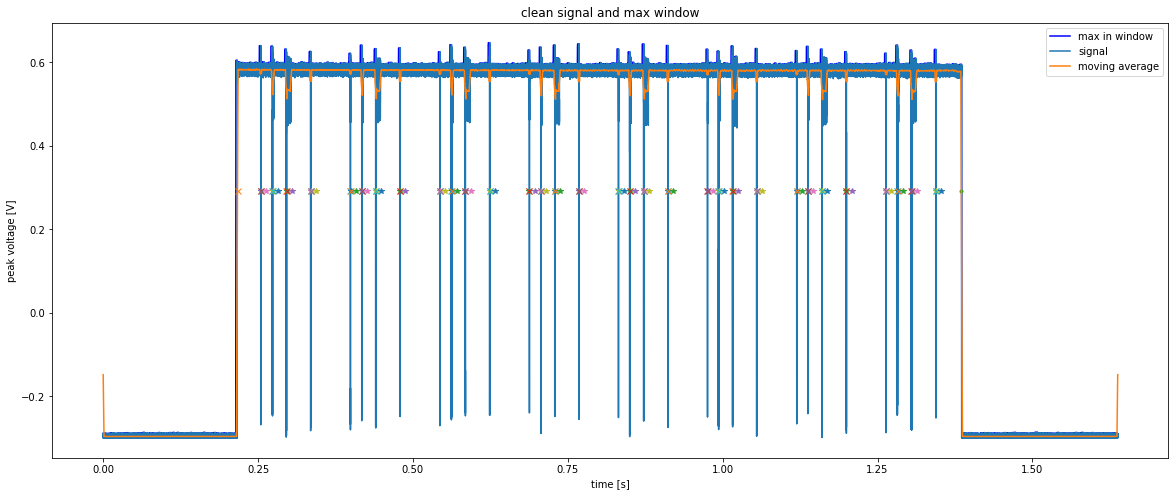

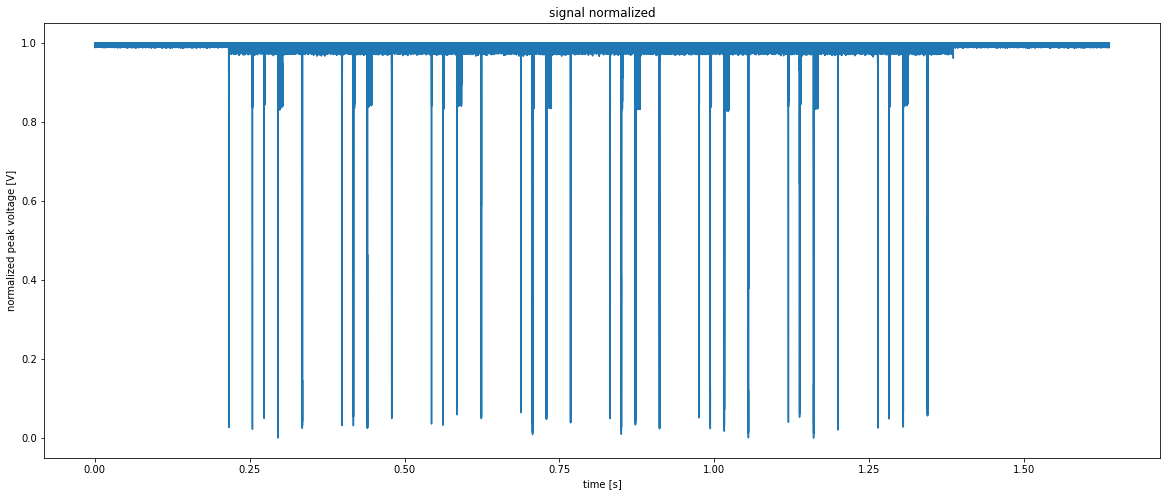

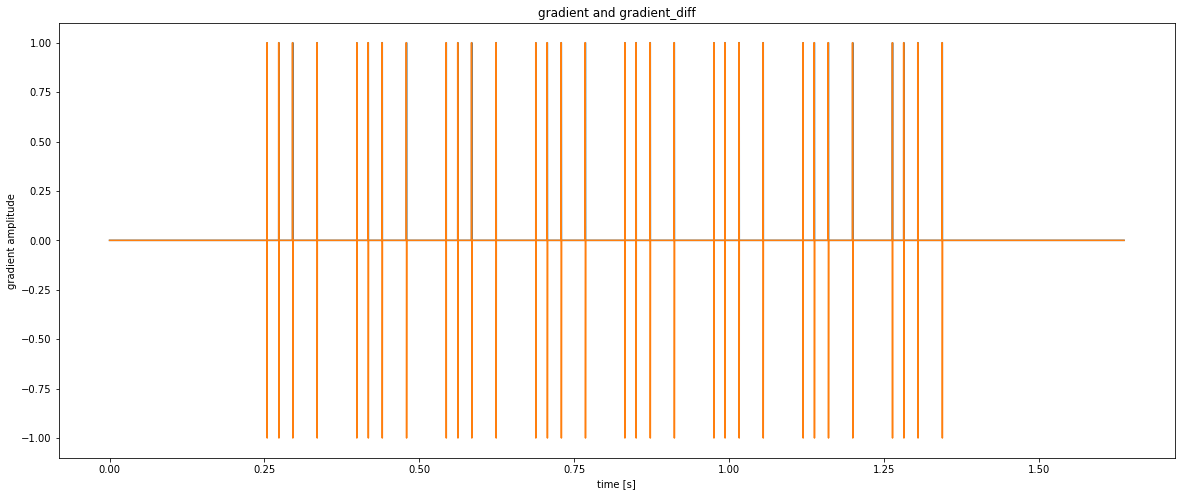

In [13]:
s.plot_clean_signal_max_window()
s.plot_normalized()
s.plot_gradient()

## Spectogram of the signal

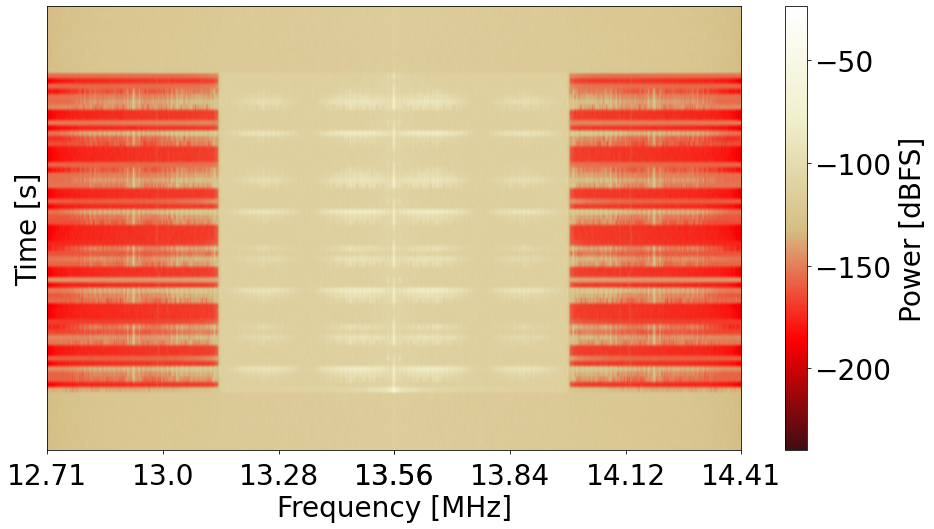

In [14]:
spectrum = s.specgram(NFFT=NFFT_gqrx, no_reader=True)

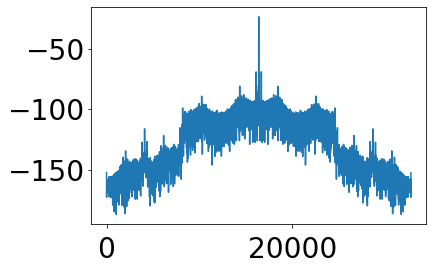

In [15]:
plt.plot(spectrum[40])

## PSD animated plot

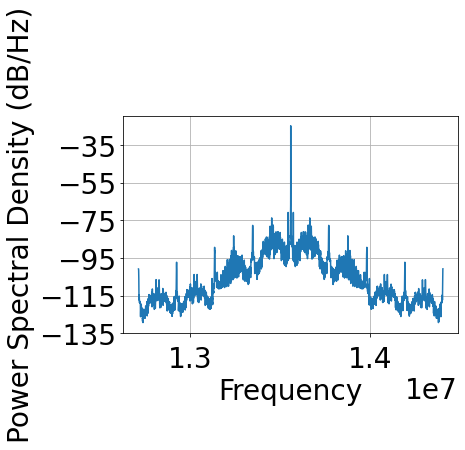

In [16]:
ani = s.get_animated_psd(Fs, NFFT, Fc)
HTML(ani.to_html5_video())

# Cards

Cards internal states change based on the command sent from the reader. Card states change depend on the type of card you are communicating with. NXP cards are widely used and used for testing in this notebook. There is a general MIFARE identification procedure (reader: RATS 0xE0 0x50 or 0xE0 0x80, card: SAK) which enables to understand which card you are communicating to. To correctly communicate with a card you must perform anticollision, described in ISO 14443 protocol. Some resources to understand anticollision are linked below.

<b>Note:</b> Cards produce lower amplitude signals compared to the reader's amplitude.

Resources:

- General states for cards in: ISO 14443-3, page 10 (Power OFF, IDLE, READY, ACTIVE).

- Mifare Ultralight EV1: https://www.nxp.com/docs/en/data-sheet/MF0ULX1.pdf

- Mifare Classic EV1: https://www.nxp.com/docs/en/data-sheet/MF1S50YYX_V1.pdf, https://link.springer.com/content/pdf/10.1007%2F978-3-540-85893-5_20.pdf, https://nickholdren.com/wp-content/uploads/2009/07/capstone.pdf, https://www.blackhat.com/docs/sp-14/materials/arsenal/sp-14-Almeida-Hacking-MIFARE-Classic-Cards-Slides.pdf, https://www.cs.bham.ac.uk/~garciaf/publications/Dismantling.Mifare.pdf

- Mifare identifaction procedure: https://www.nxp.com/docs/en/application-note/AN10833.pdf

- ISO 14443 Anticollision: https://www.nxp.com/docs/en/application-note/AN10834.pdf

We now concentrate on Mifare Ultralight EV1. To perform any type of high level communication, the card needs to be in the ACTIVE state. The card returns to IDLE (a state in which the card will not respond to READ/WRITE commands) if:
- an unexpected command is received (e.g. REQA in Active mode)
- a wrong command (to which it does not know how to answer, e.g. 0x29 0x88 + CRC) is received

Cards may return to IDLE in presence of a blocking card. If this happens, you should ensure that you restart the cycle with a WUPA command to come out of IDLE.

From our tests, cards have different antennas:
- Credit Cards have limited range antennas, probably to limit sniffing
- Mifare Classic EV1 have a good range antenna
- Mifare Ultralight EV1 have a good range antenna

Types of cards scanned by the author (ISO 14443):
- Mifare Classic (bus tickets, gym): static serial number NfcA
- Mifare Ultralight (bus tickets, ...): static serial number NfcA
- Mifare DesFire (credit card): static serial number IsoDep NfcA
- Mifare PLUS (credit card: static serial number, passport: variable serial number): IsoDep NfcA
- NXP IBM JCOP (Carta d'identita' italiana): static serial number IsoDep NfcA
- ? (Tessera sanitaria): variable serial number IsoDep NfcB

## Example: Mifare Ultralight EV1
The sequence of states that the card gets into, after receiving the reader commands is:


T:POR -> T:IDLE -> R:WUPA -> T:READY 1 -> R:READ 00 or R:SELECTION -> T:ACTIVE -> ANY COMMAND.

The sequence above might be interrupted by a wrong command or HALT (sent maliciously to force the card to be in IDLE) or by a blocking card. This is why, the sequence below should be repeated many times to have the highest chance of getting an answer from the card in hostile conditions (e.g. in presence of a blocking card, if you are far from the card, if there is a barrier between you and the card):
- R:WUPA -> T:READY 1 -> R:READ 00 or R:SELECTION -> T:ACTIVE -> ANY COMMAND (n times e.g. READ 30)
- R: 0x50 0x00 (SEND HALT COMMAND) so that the will be in idle for sure (if it was in idle, the card stay in idle, if it was in another state it will go to idle)
- ... (loop)


<b>Note</b>: even if you are not able to demodulate the answer in hostile conditions, the card may send an answer.

#  Blocking Cards Attacks
In this section blocking cards effects are analyzed.

In this notebook ten blocking cards from different manufacturers are analyzed and most of them produce similar effects:
- 9/10 produce white gaussian noise: taking the mean of many signal slices eliminates its effects
- 1/9 produces noise at various fixed frequencies.

Types of blocking cards:
- wgn blocking cards: The psd generated by blocking cards resembles the wgn psd (https://www.probabilitycourse.com/chapter10/10_2_4_white_noise.php). The frequency at which you find the noise peak is variable if the card is moving, due to the doppler effect.
The card might not respond when a blocking card is in the near field of a reader. The card may not receive the REQA or WUPA commad by the reader correctly because it is not able to demodulate the command correctly or because it is not powered on. In the latter case, the blocking card attenuates the field generated by the reader. If you are lucky you may get a response from the card in presence of a blocking card. Sometimes the card enters IDLE after a few commands, this is why sending a sequence such as the one presented in the Mifare Ultralight example is important.
- aluminium blocking cards: Do not introduce any form of noise, they only attenuates the overall signal (they might be made of aluminium foils).
- blocking cards producing noise at specific frequencies: these cards seems to be very efffective if they are close enough to be powered on by the reader. There is no response from the card to the commands sent from the reader when these cards are active.

### Profiling
To see how you can profile blocking cards, open [this notebook](Profiling.ipynb)

### Demodulation with mean
To see multiple tests of demodulating in presence of blocking cards, by taking the mean of multiple signal slices open [this notebook](Demodulation.ipynb)

### Attacking blocking cards: with a good demodulator and taking mean of multiple signal slices

To demodulate in presence of blocking cards (with the conditions presented above: e.g. the card *responds* to the reader, the loop reader sequence is pre-defined and contains a command to send the card in idle for more success), the attacker might:
1. implement a smart demodulator
2. take the mean of multiple signal slices.
3. use other ways to remove and classify noise

Taking the maean in case of wgn blocking cards works because a random process with a constant power spectral density (PSD) function is a white noise process.
- https://www.gaussianwaves.com/2013/11/simulation-and-analysis-of-white-noise-in-matlab/
- https://www.probabilitycourse.com/chapter10/10_2_4_white_noise.php#:~:text=By%20definition%2C%20the%20random%20process,02%2C%20for%20all%20f.&text=Figure%2010.8%20%2D%20Part%20(a)%3A,b)%20PSD%20of%20white%20noise.

See the [notebook](Attack-Example.ipynb)

# Simulation

Refert to [notebook](Simulation)

# Appendix

See [notebook](Appendix.ipynb)